# Zillow`s Home Value Prediction (Zestimate)

---


## Table Content
* [1. Problem statement and data collection](#c1)
* [2. Exploration and data cleaning](#c2)
    * [2.1 Understanding the features](#s21)
    * [2.2 Identifying Duplicated and Null Values](#s22)
    * [2.3 Handling Null Values and Removing Irrelevant Information](#s23)
        * [2.3.1 Using KNN to predict geolocation columns (propertycountylandusecode regionidcity, regionidzip, etc.)](#s231)
* [3. Univariate Analysis](#c3)
    * [3.1 Dividing our dataset into categorial and numerical.](#s31)
    * [3.2 Categorical Variable Analysis](#s32) 
* [4. Multivariate Analysis](#c4)
    * [4.1 Encoding Categorical Values and Saving JSON files](#s41)
    * [4.2 Numerical-Categorical Analysis (Correlation Analysis)](#s42)
* [5. Feature Engineering](#c5)
    * [5.1 New feature Inference](#s51)
    * [5.2 Outlier Analysis](#s52)
* [6. Data Processing](#c6)
    * [6.1 Feature Selection based on Importance](#s61)
    * [6.2 Split train/test](#s62)
    * [6.3 Saving Data Frames into CSV files](#s63)
### Machine Learning 
* [7.1 Decision Making: What's the best model?](#s71)
* [7.2 Model Optimization](#s72)
    * [7.2.1 LightGBM Optimization](#s721)
    * [7.2.2 Ensemble Optimization](#s722) 



---


Imported Libraries

In [86]:
# Data processing
# ==================================================================================
import pandas as pd 
import numpy as np
import math
import pickle
import requests
import urllib
from io import StringIO
import json
from concurrent.futures import ThreadPoolExecutor

# Charts
# ==================================================================================
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing and modeling
# ==================================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import VotingRegressor, RandomForestRegressor

import lightgbm as lgb

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Display Configuration
# ==================================================================================
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Warnings Configuration
# ==================================================================================
import warnings

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn # ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
'''NOTE: This affects only the display and not the underlying data, which remains unchanged.'''

'NOTE: This affects only the display and not the underlying data, which remains unchanged.'

---

## 1. Problem statement and data collection <a class="anchor" id="c1"></a>

#### --------------------**Objetivo del Análisis**--------------------

1. **Evaluar y mejorar la precisión del Zestimate:**

    - Zillow utiliza el Zestimate para estimar el valor de las viviendas, lo que ayuda a los propietarios a monitorear este activo.

    - El análisis tiene como objetivo optimizar el algoritmo detrás del Zestimate, reduciendo el margen de error y aumentando la confianza en las predicciones de valor de las propiedades.

2. **Implementar métricas de evaluación confiables:**

    - Utilizar métricas como el `logerror` y el Mean Absolute Error (`MAE`) para medir y comparar la precisión de las predicciones.
    
3. **Competencia Zillow Prize:**

    - Mejorar el Zestimate a través de una competencia de ciencia de datos que invita a los participantes a desarrollar algoritmos avanzados de predicción de precios de viviendas.


#### --------------------**Contexto del Análisis**--------------------

1. **Zestimate y su importancia:**

    - Es la herramienta de valoración de viviendas de Zillow.

    - Los valores se calculan mediante 7.5 millones de modelos estadísticos y de aprendizaje automático que analizan cientos de puntos de datos de cada propiedad.

    - Proporciona a los consumidores una estimación gratuita del valor de las viviendas y del mercado inmobiliario.

2. **Métricas de evaluación:**

    - Logerror:

        - El modelo tendrá como target (`logerror`) los errores logarítmicos de precios.

        - Mide la discrepancia entre el valor estimado (`Zestimate`) y el precio real de venta (`SalePrice`) en una escala logarítmica.

        - Fórmula:

                logerror = log(Zestimate) − log(SalePrice)

        - Ayuda a estabilizar los cálculos en datos con alta variación o valores extremos.

    - MAE (Mean Absolute Error):

        - Promedio de los errores absolutos entre las predicciones y los valores reales.

        - Es una métrica robusta e intuitiva para medir precisión.

        - Un MAE más bajo significa que el modelo predice con mayor precisión.

3. **Ventajas de las métricas seleccionadas:**

    - Logerror:

        - Normaliza las diferencias entre valores altos y bajos.

        - Maneja mejor las propiedades con escalas amplias de precios.

    - MAE:

        - Refleja de manera directa los errores en términos absolutos.

        - No penaliza en exceso los errores grandes, como lo haría el MSE (Mean Squared Error).

4. **Impacto esperado:**

    - Mejorar el Zestimate beneficia a millones de propietarios y compradores en Estados Unidos, proporcionando estimaciones más confiables y precisas del valor de las viviendas.

    - La competencia Zillow Prize impulsa la innovación en ciencia de datos mediante el desarrollo de algoritmos avanzados para un problema de gran escala.


In [11]:
# Cargamos el archivo 'properties_2016.csv' ubicado en ... en un Dataframe usando la libreria pandas

df2016 = pd.read_csv('../data/raw/properties_2016.csv')
df2016.head(3)

parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  10754147                    NaN                       NaN           NaN   
1  10759547                    NaN                       NaN           NaN   
2  10843547                    NaN                       NaN           NaN   

   bathroomcnt  bedroomcnt  buildingclasstypeid  buildingqualitytypeid  \
0        0.000       0.000                  NaN                    NaN   
1        0.000       0.000                  NaN                    NaN   
2        0.000       0.000                  NaN                    NaN   

   calculatedbathnbr  decktypeid  finishedfloor1squarefeet  \
0                NaN         NaN                       NaN   
1                NaN         NaN                       NaN   
2                NaN         NaN                       NaN   

   calculatedfinishedsquarefeet  finishedsquarefeet12  finishedsquarefeet13  \
0                           NaN                   NaN                   NaN   
1                           NaN                   NaN                   NaN   
2                     73026.000                   NaN                   NaN   

   finishedsquarefeet15  finishedsquarefeet50  finishedsquarefeet6     fips  \
0                   NaN                   NaN                  NaN 6037.000   
1                   NaN                   NaN                  NaN 6037.000   
2             73026.000                   NaN                  NaN 6037.000   

   fireplacecnt  fullbathcnt  garagecarcnt  garagetotalsqft hashottuborspa  \
0           NaN          NaN           NaN              NaN            NaN   
1           NaN          NaN           NaN              NaN            NaN   
2           NaN          NaN           NaN              NaN            NaN   

   heatingorsystemtypeid     latitude      longitude  lotsizesquarefeet  \
0                    NaN 34144442.000 -118654084.000          85768.000   
1                    NaN 34140430.000 -118625364.000           4083.000   
2                    NaN 33989359.000 -118394633.000          63085.000   

   poolcnt  poolsizesum  pooltypeid10  pooltypeid2  pooltypeid7  \
0      NaN          NaN           NaN          NaN          NaN   
1      NaN          NaN           NaN          NaN          NaN   
2      NaN          NaN           NaN          NaN          NaN   

  propertycountylandusecode  propertylandusetypeid propertyzoningdesc  \
0                      010D                269.000                NaN   
1                      0109                261.000             LCA11*   
2                      1200                 47.000               LAC2   

   rawcensustractandblock  regionidcity  regionidcounty  regionidneighborhood  \
0            60378002.041     37688.000        3101.000                   NaN   
1            60378001.011     37688.000        3101.000                   NaN   
2            60377030.012     51617.000        3101.000                   NaN   

   regionidzip  roomcnt  storytypeid  threequarterbathnbr  \
0    96337.000    0.000          NaN                  NaN   
1    96337.000    0.000          NaN                  NaN   
2    96095.000    0.000          NaN                  NaN   

   typeconstructiontypeid  unitcnt  yardbuildingsqft17  yardbuildingsqft26  \
0                     NaN      NaN                 NaN                 NaN   
1                     NaN      NaN                 NaN                 NaN   
2                     NaN    2.000                 NaN                 NaN   

   yearbuilt  numberofstories fireplaceflag  structuretaxvaluedollarcnt  \
0        NaN              NaN           NaN                         NaN   
1        NaN              NaN           NaN                         NaN   
2        NaN              NaN           NaN                  650756.000   

   taxvaluedollarcnt  assessmentyear  landtaxvaluedollarcnt  taxamount  \
0              9.000        2015.000                  9.000        NaN   
1 

In [12]:
# Cargamos el archivo 'train_2016.csv' ubicado en ... en un Dataframe usando la libreria pandas
train16 = pd.read_csv('../data/raw/train_2016_v2.csv')

# Convierte la columna transactiondate a tipo datetime
# Asegura que la columna transactiondate sea interpretada como un objeto de tipo fecha y hora (datetime64).
train16['transactiondate'] = pd.to_datetime(train16['transactiondate'])

# Extraer el día, el mes, y el año y creamos una columna para cada una respectivamente
train16['transaction_day'] = train16['transactiondate'].dt.day
train16['transaction_month'] = train16['transactiondate'].dt.month
train16['transaction_year'] = train16['transactiondate'].dt.year

# Extraer el día de la semana (0-Lunes...6-Domingo)
train16['transaction_dayofweek'] = train16['transactiondate'].dt.dayofweek

# Eliminar la columna 'transactiondate'
train16 = train16.drop(columns='transactiondate')

# Mostrar las primeras 3 filas
train16.head(3)

parcelid  logerror  transaction_day  transaction_month  transaction_year  \
0  11016594     0.028                1                  1              2016   
1  14366692    -0.168                1                  1              2016   
2  12098116    -0.004                1                  1              2016   

   transaction_dayofweek  
0                      4  
1                      4  
2                      4

---

### 2. Exploration and data cleaning <a class="anchor" id="c2"></a>
#### 2.1 Understanding the dataset <a id="s21"></a>

In [13]:
# Obtenemos dimensiones

rows, columns = df2016.shape

print(f"The dimensions of this dataset are: {rows} Rows and {columns} Columns")

The dimensions of this dataset are: 2985217 Rows and 58 Columns


In [14]:
# Obtenemos dimensiones

rows, columns = train16.shape

print(f"The dimensions of this dataset are: {rows} Rows and {columns} Columns")

The dimensions of this dataset are: 90275 Rows and 6 Columns


In [15]:
# Obtenemos la información sobre los data types y los valores no nulos

df2016.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   parcelid                      2985217 non-null  int64  
 1   airconditioningtypeid         811519 non-null   float64
 2   architecturalstyletypeid      6061 non-null     float64
 3   basementsqft                  1628 non-null     float64
 4   bathroomcnt                   2973755 non-null  float64
 5   bedroomcnt                    2973767 non-null  float64
 6   buildingclasstypeid           12629 non-null    float64
 7   buildingqualitytypeid         1938488 non-null  float64
 8   calculatedbathnbr             2856305 non-null  float64
 9   decktypeid                    17096 non-null    float64
 10  finishedfloor1squarefeet      202717 non-null   float64
 11  calculatedfinishedsquarefeet  2929652 non-null  float64
 12  finishedsquarefeet12        

| Feature                         | Description                                                                                  |
|---------------------------------|----------------------------------------------------------------------------------------------|
| airconditioningtypeid           | Type of cooling system present in the home (if any).                                         |
| architecturalstyletypeid        | Architectural style of the home (e.g., ranch, colonial, split-level, etc.).                  |
| basementsqft                    | Finished living area below or partially below ground level.                                  |
| bathroomcnt                     | Number of bathrooms in home including fractional bathrooms.                                  |
| bedroomcnt                      | Number of bedrooms in home.                                                                 |
| buildingqualitytypeid           | Overall assessment of condition of the building from best (lowest) to worst (highest).       |
| buildingclasstypeid             | The building framing type (steel frame, wood frame, concrete/brick).                        |
| calculatedbathnbr               | Number of bathrooms in home including fractional bathrooms.                                  |
| decktypeid                      | Type of deck (if any) present on parcel.                                                    |
| threequarterbathnbr             | Number of 3/4 bathrooms in house (shower + sink + toilet).                                   |
| finishedfloor1squarefeet        | Size of the finished living area on the first (entry) floor of the home.                     |
| calculatedfinishedsquarefeet    | Calculated total finished living area of the home.                                          |
| finishedsquarefeet12            | Base unfinished and finished area.                                                          |
| finishedsquarefeet13            | Perimeter living area.                                                                      |
| finishedsquarefeet15            | Finished living area.                                                                       |
| finishedsquarefeet50            | Size of the finished living area on the first (entry) floor of the home.                    |
| fips                            | Federal Information Processing Standard code (county code).                                 |
| fireplacecnt                    | Number of fireplaces in the home (if any).                                                 |
| fireplaceflag                   | Is a fireplace present in this home.                                                       |
| fullbathcnt                     | Number of full bathrooms (sink, shower + bathtub, and toilet) present in home.              |
| garagecarcnt                    | Total number of garages on the lot not including an attached garage.                        |
| garagetotalsqft                 | Total number of square feet of all garages on lot including an attached garage.             |
| hashottuborspa                  | Does the home have a hot tub or spa.                                                        |
| heatingorsystemtypeid           | Type of home heating system.                                                                |
| latitude                        | Latitude of the middle of the parcel multiplied by 10e6.                                    |
| longitude                       | Longitude of the middle of the parcel multiplied by 10e6.                                   |
| lotsizesquarefeet               | Area of the lot in square feet.                                                             |
| numberofstories                 | Number of stories or levels the home has.                                                  |
| parcelid                        | Unique identifier for parcels (lots).                                                      |
| poolcnt                         | Number of pools on the lot (if any).                                                       |
| poolsizesum                     | Total square footage of all pools on property.                                             |
| pooltypeid10                    | Spa or Hot Tub.                                                                             |
| pooltypeid2                     | Pool with Spa/Hot Tub.                                                                      |
| pooltypeid7                     | Pool without Hot Tub.                                                                       |
| propertycountylandusecode       | County land use code i.e. zoning at the county level.                                       |
| propertylandusetypeid           | Type of land use the property is zoned for.                                                |
| propertyzoningdesc              | Description of the allowed land uses (zoning) for that property.                           |
| censustractandblock             | Census tract and block ID combined - also contains blockgroup assignment by extension.      |
| rawcensustractandblock          | Census tract and block ID combined - also contains blockgroup assignment.                  |
| regionidcounty                  | County in which the property is located.                                                   |
| regionidcity                    | City in which the property is located (if any).                                            |
| regionidzip                     | Zip code in which the property is located.                                                 |
| regionidneighborhood            | Neighborhood in which the property is located.                                             |
| roomcnt                         | Total number of rooms in the principal residence.                                           |
| storytypeid                     | Type of floors in a multi-story house (e.g., basement and main level, split-level, etc.).   |
| typeconstructiontypeid          | What type of construction material was used to construct the home.                         |
| unitcnt                         | The number of units the structure is built into (e.g., 2 = duplex, 3 = triplex, etc.).      |
| yardbuildingsqft17              | Storage shed/building in yard.                                                             |
| yardbuildingsqft26              | The total tax assessed value of the parcel.                                                |
| yearbuilt                       | The year the principal residence was built.                                                |
| structuretaxvaluedollarcnt      | The assessed value of the built structure on the parcel.                                    |
| landtaxvaluedollarcnt           | The land value of the land area of the parcel.                                             |
| taxvaluedollarcnt               | The total property tax assessed for that assessment year.                                   |
| assessmentyear                  | The year of the property tax assessment.                                                   |
| taxamount                       | The total property tax assessed as of 2015.                                                |
| taxdelinquencyflag              | Property taxes for this parcel are past due.                                               |
| taxdelinquencyyear              | Year for which the taxes are past due.                                                     |


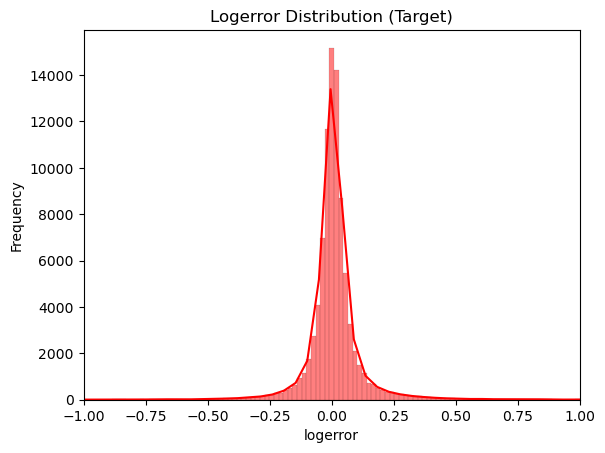

In [16]:
# Check the the target distribution
sns.histplot(data=train16['logerror'], bins=500, kde=True, color='red')
plt.xlim(-1, 1)
plt.title('Logerror Distribution (Target)')
plt.xlabel('logerror')
plt.ylabel('Frequency')
plt.show()

----------**Conclusiones**----------

- En el Dataframe `df2016` hay un total de 2_985_217 filas y 58 columnas.

- En el Dataframe `train16` hay un total de 90_275 filas y 6 columnas.

- Tenemos un total de 53 características numéricas y 5 características categóricas.

---

#### 2.2 Identifying Duplicated and Null Values <a id="s22"></a>

In [17]:
# Obtain the number of duplicate values in our dataset

print(f"The number of duplicate values in the dataset is {df2016.duplicated().sum()}")

The number of duplicate values in the dataset is 0


----------Additions----------

>NOTE: En este caso no hemos encontrado ningún valor duplicado. En el caso de haberlo encontrado, el siguiente paso sería aplicar la función `drop_duplicates()`.

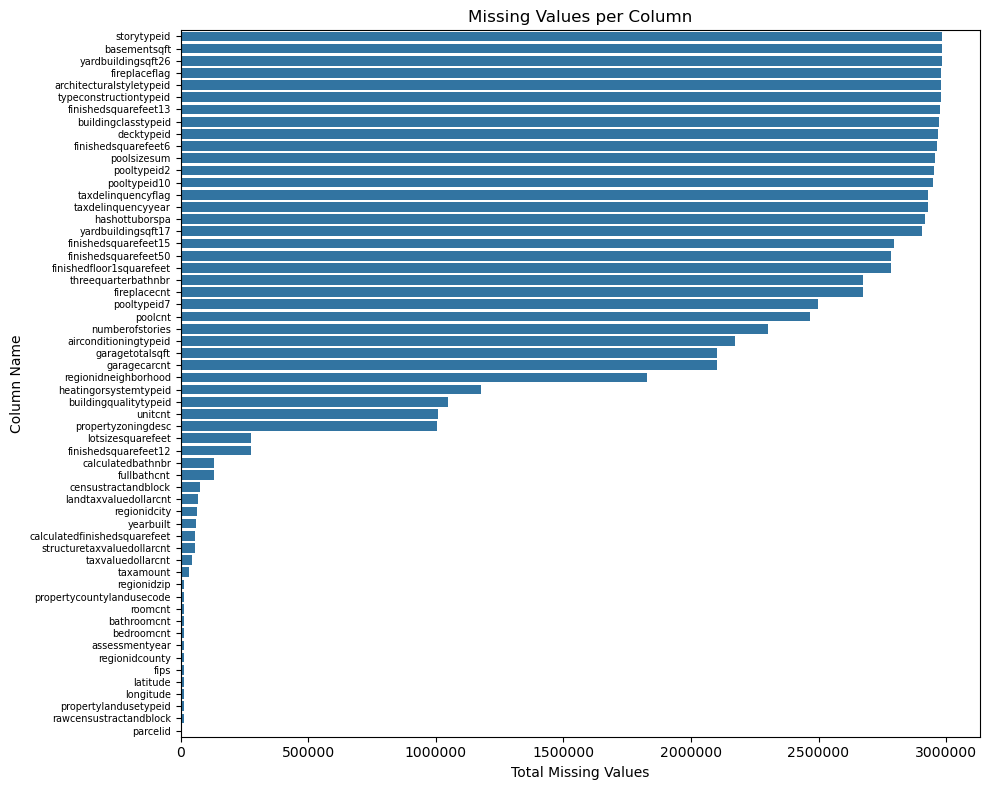

In [18]:
from matplotlib.ticker import FuncFormatter

# Checking how many null values we have per columns in our DataFrame
# .isnull() Devuelve un booleano donde los valores nulos son True y False los que no lo son
# Obtener el valor total de nulos por columna
missing = df2016.isnull().sum().reset_index() 

missing.columns = ['columnname', # Nombre de la columna original
                    'count'] # Cantidad de valores nulos de esa columna

# Ordena el DataFrame missing en orden descendente según la cantidad de valores nulos (count).
missing = missing.sort_values('count', ascending=False)

# Configurar el tamaño del gráfico a 10x8
plt.figure(figsize=(10,8))

sns.barplot(x='count',
             y='columnname',
               data=missing)

plt.title('Missing Values per Column')

plt.ylabel('Column Name')

plt.yticks(fontsize=7,
            fontweight='light')

plt.xlabel('Total Missing Values')

plt.ticklabel_format(style='plain', axis='x')

# Ajustar automáticamente el espacio entre los elementos del gráfico para evitar solapamientos.
plt.tight_layout()
# Mostrar
plt.show()


----------**Conclusiones**----------

1. Columnas con más valores faltantes:

    - Las columnas en la parte superior, como `storytypeid`, `basementsqft`, y otras, tienen una gran cantidad de valores nulos, llegando a casi 3 millones en algunos casos.

    - Esto sugiere que estas columnas están incompletas y podrían no ser útiles en el análisis o requerir estrategias avanzadas de imputación.

2. Columnas con pocos valores faltantes:

    - Las columnas más cercanas a la parte inferior tienen menos valores nulos, lo que indica que están más completas. Por ejemplo, `latitude`, `longitude`, y `parcelid` parecen tener pocos o ningún valor nulo.

3. Decisiones posibles:

    - Las columnas con muchos valores faltantes podrían eliminarse si no contienen información crucial. Sin embargo, en este caso hemos decidido conservarlas, ya que la ausencia de datos indica que dicho elemento no está presente en la casa, lo cual es relevante para el análisis de precios.

    - Para las columnas con valores faltantes moderados, podrías considerar técnicas de imputación (relleno) como usar la media, mediana, o un modelo predictivo (KNN).
    

---

#### 2.3 Handling Null Values and Removing Irrelevant Information <a id="s23"></a>


In [19]:
# Columnas que representan áreas en metros cuadrados (sqm) y donde NaN indica la ausencia de esa característica.
sqm_columns = ['basementsqft', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
                'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
                  'finishedsquarefeet50', 'finishedsquarefeet6', 'poolsizesum',
                    'garagetotalsqft', 'yardbuildingsqft17', 'yardbuildingsqft26']

#.fillna(0): Los valores nulos (NaN) en esta columna se reemplazan con 0 (indicando ausencia de características)
df2016[sqm_columns] = df2016[sqm_columns].fillna(0)

In [20]:
# Columns representing counts (e.g., number of rooms, pools), where NaN indicates the absence of the feature.
count_columns = ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
                  'fireplacecnt', 'fullbathcnt', 'garagecarcnt',
                    'numberofstories', 'poolcnt', 'roomcnt',
                      'threequarterbathnbr', 'unitcnt'] 

#.fillna(0): Los valores nulos (NaN) en esta columna se reemplazan con 0 (indicando ausencia de características)
df2016[count_columns] = df2016[count_columns].fillna(0)

In [21]:
# Columnas booleanas donde la presencia de una característica no se marcó explícitamente como Falso. Convirtiendo estas columnas a binarias
# format: 1 for positive and 0 for negative.
df2016['hashottuborspa'] = df2016['hashottuborspa'].apply(lambda x: 1 if x==True else 0)

df2016['fireplaceflag'] = df2016['fireplaceflag'].apply(lambda x: 1 if x==True else 0)

df2016['taxdelinquencyflag'] = df2016['taxdelinquencyflag'].apply(lambda x: 1 if x=='Y' else 0)

In [22]:
# Removing rows with missing location data - 'location' columns are essential for identifying properties geographically. 
# Rows with all null values in these columns are dropped (11,437 rows removed, which represents ~0.40% of the dataset).
location = ['regionidzip', 'fips', 'regionidcounty',
             'longitude', 'latitude', 'censustractandblock',
               'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity']

no_loc_index = df2016[df2016[location].isna().all(axis=1)].index

df2016 = df2016.drop(df2016.index[no_loc_index])

In [23]:
# For properties where 'poolcnt' is 0 (indicating no pools are present), all related columns, such as pool size and pool types, 
# should be filled with zero. 
pool_related = ['poolsizesum',
                 'pooltypeid10',
                   'pooltypeid2',
                     'pooltypeid7']

df2016.loc[df2016['poolcnt'] == 0, pool_related] = 0

In [24]:
# Validating that the 'pool_types' columns correctly represent pool features across all rows. If 'pooldif' is 0 (indicating no diference), 
# all related pool columns can safely be filled with 0

pool_types = ['pooltypeid10', 'pooltypeid2', 'pooltypeid7']

df2016['poolcount2'] = df2016[pool_types].sum(axis=1)

df2016['pooldif'] = df2016['poolcnt'] - df2016['poolcount2']

df2016[df2016['pooldif']!=0]

Empty DataFrame
Columns: [parcelid, airconditioningtypeid, architecturalstyletypeid, basementsqft, bathroomcnt, bedroomcnt, buildingclasstypeid, buildingqualitytypeid, calculatedbathnbr, decktypeid, finishedfloor1squarefeet, calculatedfinishedsquarefeet, finishedsquarefeet12, finishedsquarefeet13, finishedsquarefeet15, finishedsquarefeet50, finishedsquarefeet6, fips, fireplacecnt, fullbathcnt, garagecarcnt, garagetotalsqft, hashottuborspa, heatingorsystemtypeid, latitude, longitude, lotsizesquarefeet, poolcnt, poolsizesum, pooltypeid10, pooltypeid2, pooltypeid7, propertycountylandusecode, propertylandusetypeid, propertyzoningdesc, rawcensustractandblock, regionidcity, regionidcounty, regionidneighborhood, regionidzip, roomcnt, storytypeid, threequarterbathnbr, typeconstructiontypeid, unitcnt, yardbuildingsqft17, yardbuildingsqft26, yearbuilt, numberofstories, fireplaceflag, structuretaxvaluedollarcnt, taxvaluedollarcnt, assessmentyear, landtaxvaluedollarcnt, taxamount, taxdelinquencyflag, taxdelinquencyyear, censustractandblock, poolcount2, pooldif]
Index: []

In [25]:
# Filling up all columns within 'pool_types' list and dropping previously created columns 
df2016[pool_types] = df2016[pool_types].fillna(0)
new_cols = ['poolcount2', 'pooldif']
df2016 = df2016.drop(columns=new_cols)

In [26]:
# Columns representing Null as non existent (Assumption)
non_existent = ['airconditioningtypeid', 'decktypeid', 'heatingorsystemtypeid', 'taxdelinquencyyear']
df2016[non_existent] = df2016[non_existent].fillna(0)

In [27]:
# Correcting scales for geoloc columsn (lat & lon)
df2016['latitude'], df2016['longitude'] = df2016['latitude']/(10**6), df2016['longitude']/(10**6)
df2016.head(3)

parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  10754147                  0.000                       NaN         0.000   
1  10759547                  0.000                       NaN         0.000   
2  10843547                  0.000                       NaN         0.000   

   bathroomcnt  bedroomcnt  buildingclasstypeid  buildingqualitytypeid  \
0        0.000       0.000                  NaN                    NaN   
1        0.000       0.000                  NaN                    NaN   
2        0.000       0.000                  NaN                    NaN   

   calculatedbathnbr  decktypeid  finishedfloor1squarefeet  \
0              0.000       0.000                     0.000   
1              0.000       0.000                     0.000   
2              0.000       0.000                     0.000   

   calculatedfinishedsquarefeet  finishedsquarefeet12  finishedsquarefeet13  \
0                         0.000                 0.000                 0.000   
1                         0.000                 0.000                 0.000   
2                     73026.000                 0.000                 0.000   

   finishedsquarefeet15  finishedsquarefeet50  finishedsquarefeet6     fips  \
0                 0.000                 0.000                0.000 6037.000   
1                 0.000                 0.000                0.000 6037.000   
2             73026.000                 0.000                0.000 6037.000   

   fireplacecnt  fullbathcnt  garagecarcnt  garagetotalsqft  hashottuborspa  \
0         0.000        0.000         0.000            0.000               0   
1         0.000        0.000         0.000            0.000               0   
2         0.000        0.000         0.000            0.000               0   

   heatingorsystemtypeid  latitude  longitude  lotsizesquarefeet  poolcnt  \
0                  0.000    34.144   -118.654          85768.000    0.000   
1                  0.000    34.140   -118.625           4083.000    0.000   
2                  0.000    33.989   -118.395          63085.000    0.000   

   poolsizesum  pooltypeid10  pooltypeid2  pooltypeid7  \
0        0.000         0.000        0.000        0.000   
1        0.000         0.000        0.000        0.000   
2        0.000         0.000        0.000        0.000   

  propertycountylandusecode  propertylandusetypeid propertyzoningdesc  \
0                      010D                269.000                NaN   
1                      0109                261.000             LCA11*   
2                      1200                 47.000               LAC2   

   rawcensustractandblock  regionidcity  regionidcounty  regionidneighborhood  \
0            60378002.041     37688.000        3101.000                   NaN   
1            60378001.011     37688.000        3101.000                   NaN   
2            60377030.012     51617.000        3101.000                   NaN   

   regionidzip  roomcnt  storytypeid  threequarterbathnbr  \
0    96337.000    0.000          NaN                0.000   
1    96337.000    0.000          NaN                0.000   
2    96095.000    0.000          NaN                0.000   

   typeconstructiontypeid  unitcnt  yardbuildingsqft17  yardbuildingsqft26  \
0                     NaN    0.000               0.000               0.000   
1                     NaN    0.000               0.000               0.000   
2                     NaN    2.000               0.000               0.000   

   yearbuilt  numberofstories  fireplaceflag  structuretaxvaluedollarcnt  \
0        NaN            0.000              0                         NaN   
1        NaN            0.000              0                         NaN   
2        NaN            0.000              0                  650756.000   

   taxvaluedollarcnt  assessmentyear  landtaxvaluedollarcnt  taxamount  \
0              9.000        2015.000                  9.000        NaN   
1          27516.000  

In [29]:
# Function to get missing 'censustractandblock'
def getcensustractandblock(lat, lon):
    try: 
        params = urllib.parse.urlencode({'latitude': lat, 'longitude':lon, 'format':'json'})
        url = 'https://geo.fcc.gov/api/census/block/find?' + params
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            return data['Block']['FIPS']
        else: 
            print(f'Error: Received status code {response.status_code} for lat: {lat}, lon: {lon}')
    except Exception as e: 
        print(f'Error fetching info for lat: {lat}, lon {lon}')

def process_row(lat, lon):
    return getcensustractandblock(lat, lon)

coords_to_process = df2016[df2016['censustractandblock'].isnull()][['latitude', 'longitude']].drop_duplicates()

coord_to_fips = {}

# Parallel process -> Do not change the max_workers to more than 500, otherwise the page url won't work. 
with ThreadPoolExecutor(max_workers=500) as executor:
    results = executor.map(lambda row: (row['latitude'], row['longitude'], process_row(row['latitude'], row['longitude'])),
                           coords_to_process.to_dict(orient='records'))

    for lat, lon, fips in results:
        coord_to_fips[(lat, lon)] = fips

df2016['censustractandblock'] = df2016.apply(lambda row: coord_to_fips.get((row['latitude'], row['longitude']), row['censustractandblock']), axis=1)

In [30]:
df2016['censustractandblock'] = df2016['censustractandblock'].astype('int64')

# Cambia el tipo de datos de la columna censustractandblock para que almacene valores como enteros de 64 bits en lugar de otro tipo (como float64 o object).

In [31]:
# Guarda el DataFrame `df2016` en un archivo .CSV

df2016.to_csv('../data/processed/df_with_censustract.csv', index=False)

---

##### 2.3.1 Using KNN to predict geolocation columns (propertycountylandusecode regionidcity, regionidzip, etc.) <a id="s231"></a>

In [32]:
# Preparing lat and lon for our KNN model
data = df2016[['latitude', 'longitude']]
scaler = StandardScaler()
scaler.fit(data)
scaled = scaler.transform(data)
df2016[['lat_scaled', 'long_scaled']] = scaled

---

##### 2.3.1.1 regionidcity

In [33]:
# Creating a train and a test set (train is no null values while test will be the null values where we want to predict. )
train_data = df2016.dropna(subset=['lat_scaled', 'long_scaled', 'regionidcity'])
test_data = df2016[df2016['regionidcity'].isnull()]

X_train = train_data[['lat_scaled', 'long_scaled']]
y_train = train_data['regionidcity']
X_test = test_data[['lat_scaled', 'long_scaled']]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [32]:
# Initial prediction of best_params_ = 10 -> params tested [5, 10, 15, 20, 25]
params={'n_neighbors': [8, 9, 10, 11, 12]}
grid=GridSearchCV(KNeighborsClassifier(), params, cv=5)
grid.fit(X_train, y_train)

print(f"Best params: {grid.best_params_['n_neighbors']}")

Best params: 9


In [34]:
model=KNeighborsClassifier(n_neighbors=9)
model.fit(X_train, y_train)
accuracy=model.score(X_val, y_val)
print(f"KNN Accuracy for 'regionidcity': {accuracy * 100:.2f}%")

KNN Accuracy for 'regionidcity': 99.68%


In [35]:
df2016.loc[df2016['regionidcity'].isnull(), 'regionidcity'] = model.predict(X_test)

In [36]:
# Verify that there are no missing values left in the 'regionidcity' column
df2016['regionidcity'].isnull().sum()

0

---

##### 2.3.1.2 propertycountylandusecode

In [37]:
# propertycountylandusecode
# Creating a train and a test set (train is no null values while test will be the null values where we want to predict. )
train_data = df2016.dropna(subset=['propertycountylandusecode', 'lat_scaled', 'long_scaled', 'regionidcity', 'regionidcounty'])
test_data = df2016[df2016['propertycountylandusecode'].isnull()]

X_train = train_data[['lat_scaled', 'long_scaled', 'regionidcity', 'regionidcounty']]
y_train = train_data['propertycountylandusecode']
X_test = test_data[['lat_scaled', 'long_scaled', 'regionidcity', 'regionidcounty']]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [39]:
# Initial prediction of best_params_ = 5 -> params tested [5, 10, 15, 20, 25]
params={'n_neighbors': [3, 4, 5, 6, 7]}
grid=GridSearchCV(KNeighborsClassifier(), params, cv=5)
grid.fit(X_train, y_train)

print(f"Best params: {grid.best_params_['n_neighbors']}")

Best params: 4


In [38]:
model=KNeighborsClassifier(n_neighbors=4)
model.fit(X_train, y_train)
accuracy=model.score(X_val, y_val)
print(f"KNN Accuracy for 'propertycountylandusecode': {accuracy * 100:.2f}%")

KNN Accuracy for 'propertycountylandusecode': 82.96%


In [39]:
df2016.loc[df2016['propertycountylandusecode'].isnull(), 'propertycountylandusecode'] = model.predict(X_test)

In [40]:
# Verify that there are no missing values left in the 'propertycountylandusecode' column
df2016['propertycountylandusecode'].isnull().sum()

0

---

##### 2.3.1.3 regionidzip

In [41]:
# regionidzip
# Creating a train and a test set (train is no null values while test will be the null values where we want to predict. )
train_data = df2016.dropna(subset=['regionidzip', 'lat_scaled', 'long_scaled'])
test_data = df2016[df2016['regionidzip'].isnull()]

X_train = train_data[['lat_scaled', 'long_scaled',]]
y_train = train_data['regionidzip']
X_test = test_data[['lat_scaled', 'long_scaled',]]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [121]:
# Initial prediction of best_params_ = 5 -> params tested [5, 10, 15, 20, 25]
# Second prediction of best_params_ = 3 -> params tested [3, 4, 5, 6, 7]
params={'n_neighbors': [1, 2, 3, 4, 5]}
grid=GridSearchCV(KNeighborsClassifier(), params, cv=5)
grid.fit(X_train, y_train)

print(f"Best params: {grid.best_params_['n_neighbors']}")

Best params: 1


In [42]:
model=KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train)
accuracy=model.score(X_val, y_val)
print(f"KNN Accuracy for 'regionidzip': {accuracy * 100:.2f}%")

KNN Accuracy for 'regionidzip': 99.75%


In [43]:
df2016.loc[df2016['regionidzip'].isnull(), 'regionidzip'] = model.predict(X_test)

In [44]:
# Verify that there are no missing values left in the 'regionidzip' column
df2016['regionidzip'].isnull().sum()

0

---

##### 2.3.1.4 propertyzoningdesc

In [45]:
df2016['propertyzoningdesc'] = df2016['propertyzoningdesc'].apply(lambda x: str(x) if pd.notnull(x) else x)
# Creating a train and a test set (train is no null values while test will be the null values where we want to predict. )
train_data = df2016.dropna(subset=['lat_scaled', 'long_scaled', 'propertyzoningdesc'])
test_data = df2016[df2016['propertyzoningdesc'].isnull()]

X_train = train_data[['lat_scaled', 'long_scaled']]
y_train = train_data['propertyzoningdesc']
X_test = test_data[['lat_scaled', 'long_scaled']]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [129]:
# Initial prediction of best_params_ = 5 -> params tested [5, 10, 15, 20, 25]
# Second prediction of best_params_ = 3 -> params tested [3, 4, 5, 6, 7]
params={'n_neighbors': [1, 2, 3, 4, 5]}
grid=GridSearchCV(KNeighborsClassifier(), params, cv=5)
grid.fit(X_train, y_train)

print(f"Best params: {grid.best_params_['n_neighbors']}")

Best params: 1


In [46]:
model=KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train)
accuracy=model.score(X_val, y_val)
print(f"KNN Accuracy for 'propertyzoningdesc': {accuracy * 100:.2f}%")

KNN Accuracy for 'propertyzoningdesc': 90.25%


In [47]:
df2016.loc[df2016['propertyzoningdesc'].isnull(), 'propertyzoningdesc'] = model.predict(X_test)

---

##### 2.3.1.5 regionidneighborhood

In [48]:
# regionidneighborhood
# df2016['regionidneighborhood'] = df2016['regionidneighborhood'].apply(lambda x: str(x) if pd.notnull(x) else x)

# Creating a train and a test set (train is no null values while test will be the null values where we want to predict. )
train_data = df2016.dropna(subset=['fips', 'lat_scaled', 'long_scaled', 'regionidneighborhood'])
test_data = df2016[df2016['regionidneighborhood'].isnull()]

X_train = train_data[['fips', 'lat_scaled', 'long_scaled']]
y_train = train_data['regionidneighborhood']
X_test = test_data[['fips', 'lat_scaled', 'long_scaled']]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [135]:
# Initial prediction of best_params_ = 5 -> params tested [5, 10, 15, 20, 25]
# Second prediction of best_params_ = 3 -> params tested [3, 4, 5, 6, 7]
params={'n_neighbors': [1, 2, 3, 4, 5]}
grid=GridSearchCV(KNeighborsClassifier(), params, cv=5)
grid.fit(X_train, y_train)

print(f"Best params: {grid.best_params_['n_neighbors']}")

Best params: 1


In [49]:
model=KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train)
accuracy=model.score(X_val, y_val)
print(f"KNN Accuracy for 'propertyzoningdesc': {accuracy * 100:.2f}%")

KNN Accuracy for 'propertyzoningdesc': 99.45%


In [50]:
df2016.loc[df2016['regionidneighborhood'].isnull(), 'regionidneighborhood'] = model.predict(X_test)

In [51]:
# Verify that there are no missing values left in the 'regionidneighborhood' column
df2016['regionidneighborhood'].isnull().sum()

0

---

##### 2.3.1.6 buildingqualitytypeid

In [52]:
# buildingqualitytypeid -> Assuming the nearest buildings have the same quality type. 
# Creating a train and a test set (train is no null values while test will be the null values where we want to predict. )
train_data = df2016.dropna(subset=['lat_scaled', 'long_scaled', 'buildingqualitytypeid'])
test_data = df2016[df2016['buildingqualitytypeid'].isnull()]

X_train = train_data[['lat_scaled', 'long_scaled']]
y_train = train_data['buildingqualitytypeid']
X_test = test_data[['lat_scaled', 'long_scaled']]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [142]:
# Initial prediction of best_params_
params={'n_neighbors': [3, 4, 5, 6, 7]}
grid=GridSearchCV(KNeighborsClassifier(), params, cv=5)
grid.fit(X_train, y_train)

print(f"Best params: {grid.best_params_['n_neighbors']}")

Best params: 5


In [53]:
model=KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
accuracy=model.score(X_val, y_val)
print(f"KNN Accuracy for 'propertyzoningdesc': {accuracy * 100:.2f}%")

KNN Accuracy for 'propertyzoningdesc': 88.38%


In [54]:
df2016.loc[df2016['buildingqualitytypeid'].isnull(), 'buildingqualitytypeid'] = model.predict(X_test)

In [55]:
# Verify that there are no missing values left in the 'regionidneighborhood' column
df2016['buildingqualitytypeid'].isnull().sum()

0

In [56]:
# Identifying columns with higher nulls than the threshold (null_cap = 50%) and dropping them. 
null_cap = 0.95
cols_maxcap = []

for col in df2016.columns:
    if ((df2016[col].isna().sum())/len(df2016)) > null_cap:
        cols_maxcap.append(col)

df2016 = df2016.drop(columns=cols_maxcap).reset_index(drop=True)


In [57]:
# Dropping the rows where there are still nulls 
null_cols = df2016.isna().sum()[df2016.isna().sum()>0].index.to_list()
df = df2016.dropna(subset=null_cols)
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

-----------------------------------------------------

In [58]:
# Guarda el DataFrame `df2016` en un archivo .CSV

df2016.to_csv('../data/processed/df2016_fullyprocessed.csv', index=False)

-----------------------------------------------------

In [59]:
df2016 = pd.read_csv('../data/processed/df2016_fullyprocessed.csv')

In [60]:
# Fusionar las dos tablas

df_merged = train16.merge(df2016,
                           on='parcelid',
                             how='left')
df_merged.head(3)

parcelid  logerror  transaction_day  transaction_month  transaction_year  \
0  11016594     0.028                1                  1              2016   
1  14366692    -0.168                1                  1              2016   
2  12098116    -0.004                1                  1              2016   

   transaction_dayofweek  airconditioningtypeid  basementsqft  bathroomcnt  \
0                      4                  1.000         0.000        2.000   
1                      4                  0.000         0.000        3.500   
2                      4                  1.000         0.000        3.000   

   bedroomcnt  buildingqualitytypeid  calculatedbathnbr  decktypeid  \
0       3.000                  4.000              2.000       0.000   
1       4.000                  4.000              3.500       0.000   
2       2.000                  4.000              3.000       0.000   

   finishedfloor1squarefeet  calculatedfinishedsquarefeet  \
0                     0.000                      1684.000   
1                     0.000                      2263.000   
2                     0.000                      2217.000   

   finishedsquarefeet12  finishedsquarefeet13  finishedsquarefeet15  \
0              1684.000                 0.000                 0.000   
1              2263.000                 0.000                 0.000   
2              2217.000                 0.000                 0.000   

   finishedsquarefeet50  finishedsquarefeet6     fips  fireplacecnt  \
0                 0.000                0.000 6037.000         0.000   
1                 0.000                0.000 6059.000         0.000   
2                 0.000                0.000 6037.000         0.000   

   fullbathcnt  garagecarcnt  garagetotalsqft  hashottuborspa  \
0        2.000         0.000            0.000               0   
1        3.000         2.000          468.000               0   
2        3.000         0.000            0.000               0   

   heatingorsystemtypeid  latitude  longitude  lotsizesquarefeet  poolcnt  \
0                  2.000    34.281   -118.489           7528.000    0.000   
1                  0.000    33.668   -117.678           3643.000    0.000   
2                  2.000    34.136   -118.175          11423.000    0.000   

   poolsizesum  pooltypeid10  pooltypeid2  pooltypeid7  \
0        0.000         0.000        0.000        0.000   
1        0.000         0.000        0.000        0.000   
2        0.000         0.000        0.000        0.000   

  propertycountylandusecode  propertylandusetypeid propertyzoningdesc  \
0                      0100                261.000               LARS   
1                         1                261.000              LBPD1   
2                      0100                261.000               PSR6   

   rawcensustractandblock  regionidcity  regionidcounty  regionidneighborhood  \
0            60371066.461     12447.000        3101.000             31817.000   
1            60590524.222     32380.000        1286.000            403197.000   
2            60374638.003     47019.000        3101.000            275411.000   

   regionidzip  roomcnt  threequarterbathnbr  unitcnt  yardbuildingsqft17  \
0    96370.000    0.000                0.000    1.000               0.000   
1    96962.000    0.000                1.000    0.000               0.000   
2    96293.000    0.000                0.000    1.000               0.000   

   yardbuildingsqft26  yearbuilt  numberofstories  fireplaceflag  \
0               0.000   1959.000            0.000              0   
1               0.000   2014.000            0.000              0   
2               0.000   1940.000            0.000              0   

   structuretaxvaluedollarcnt  taxvaluedollarcnt  assessmentyear  \
0                  122754.000         360170.000        2015.000   
1                  346458.000         585529.000        2015.000   
2                   61994.000         119906.000        2015.000  

In [61]:
# Removing missing values

df_merged = df_merged.dropna()
df_merged.head(3)

parcelid  logerror  transaction_day  transaction_month  transaction_year  \
0  11016594     0.028                1                  1              2016   
1  14366692    -0.168                1                  1              2016   
2  12098116    -0.004                1                  1              2016   

   transaction_dayofweek  airconditioningtypeid  basementsqft  bathroomcnt  \
0                      4                  1.000         0.000        2.000   
1                      4                  0.000         0.000        3.500   
2                      4                  1.000         0.000        3.000   

   bedroomcnt  buildingqualitytypeid  calculatedbathnbr  decktypeid  \
0       3.000                  4.000              2.000       0.000   
1       4.000                  4.000              3.500       0.000   
2       2.000                  4.000              3.000       0.000   

   finishedfloor1squarefeet  calculatedfinishedsquarefeet  \
0                     0.000                      1684.000   
1                     0.000                      2263.000   
2                     0.000                      2217.000   

   finishedsquarefeet12  finishedsquarefeet13  finishedsquarefeet15  \
0              1684.000                 0.000                 0.000   
1              2263.000                 0.000                 0.000   
2              2217.000                 0.000                 0.000   

   finishedsquarefeet50  finishedsquarefeet6     fips  fireplacecnt  \
0                 0.000                0.000 6037.000         0.000   
1                 0.000                0.000 6059.000         0.000   
2                 0.000                0.000 6037.000         0.000   

   fullbathcnt  garagecarcnt  garagetotalsqft  hashottuborspa  \
0        2.000         0.000            0.000               0   
1        3.000         2.000          468.000               0   
2        3.000         0.000            0.000               0   

   heatingorsystemtypeid  latitude  longitude  lotsizesquarefeet  poolcnt  \
0                  2.000    34.281   -118.489           7528.000    0.000   
1                  0.000    33.668   -117.678           3643.000    0.000   
2                  2.000    34.136   -118.175          11423.000    0.000   

   poolsizesum  pooltypeid10  pooltypeid2  pooltypeid7  \
0        0.000         0.000        0.000        0.000   
1        0.000         0.000        0.000        0.000   
2        0.000         0.000        0.000        0.000   

  propertycountylandusecode  propertylandusetypeid propertyzoningdesc  \
0                      0100                261.000               LARS   
1                         1                261.000              LBPD1   
2                      0100                261.000               PSR6   

   rawcensustractandblock  regionidcity  regionidcounty  regionidneighborhood  \
0            60371066.461     12447.000        3101.000             31817.000   
1            60590524.222     32380.000        1286.000            403197.000   
2            60374638.003     47019.000        3101.000            275411.000   

   regionidzip  roomcnt  threequarterbathnbr  unitcnt  yardbuildingsqft17  \
0    96370.000    0.000                0.000    1.000               0.000   
1    96962.000    0.000                1.000    0.000               0.000   
2    96293.000    0.000                0.000    1.000               0.000   

   yardbuildingsqft26  yearbuilt  numberofstories  fireplaceflag  \
0               0.000   1959.000            0.000              0   
1               0.000   2014.000            0.000              0   
2               0.000   1940.000            0.000              0   

   structuretaxvaluedollarcnt  taxvaluedollarcnt  assessmentyear  \
0                  122754.000         360170.000        2015.000   
1                  346458.000         585529.000        2015.000   
2                   61994.000         119906.000        2015.000  

In [62]:
# Devuelve una serie con los nombres de las columnas que tienen valores nulos como índice y el número de nulos en cada columna como valores.
df_merged.isna().sum()[df_merged.isna().sum()>0]

Series([], dtype: int64)

---

### 3. Univariate Analysis <a class="anchor" id="c3"></a>
#### 3.1 Dividing our dataset into categorial and numerical. <a id="s31"></a>

In [63]:
# Understanding how many type of features we have
df_merged.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('int32'), dtype('O')],
      dtype=object)

In [64]:
categorical_var = []

for column in df_merged: 

    if df_merged[column].dtype == 'object':

        categorical_var.append(column)


print(f"Categorical Variables are:\n{categorical_var}\n\nTotal = {len(categorical_var)}")

Categorical Variables are:
['propertycountylandusecode', 'propertyzoningdesc']

Total = 2


In [65]:
numerical_var_int = []
numerical_var_float = []

for column in df_merged: 

    if (df_merged[column].dtype == 'int64') :

        numerical_var_int.append(column)

    elif (df_merged[column].dtype == 'float64'):

        numerical_var_float.append(column)

print('============================================')
print(f"Numerical (int) Variables are:\n\n{numerical_var_int}\n\nTotal = {len(numerical_var_int)}")
print('============================================')
print(f"Numerical (float64) Variables are:\n\n{numerical_var_float}\n\nTotal = {len(numerical_var_float)}")
print('============================================')

Numerical (int) Variables are:

['parcelid', 'hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag', 'censustractandblock']

Total = 5
Numerical (float64) Variables are:

['logerror', 'airconditioningtypeid', 'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedolla

In [66]:
# Dividing our dataframe by numerical and categorical features
num = ['float64', 'int64', 'int32']
cat = ['O']

df_num = df_merged.select_dtypes(num)
df_cat = df_merged.select_dtypes(cat)

---

#### 3.2 Categorical Variable Analysis <a id="s32"></a>

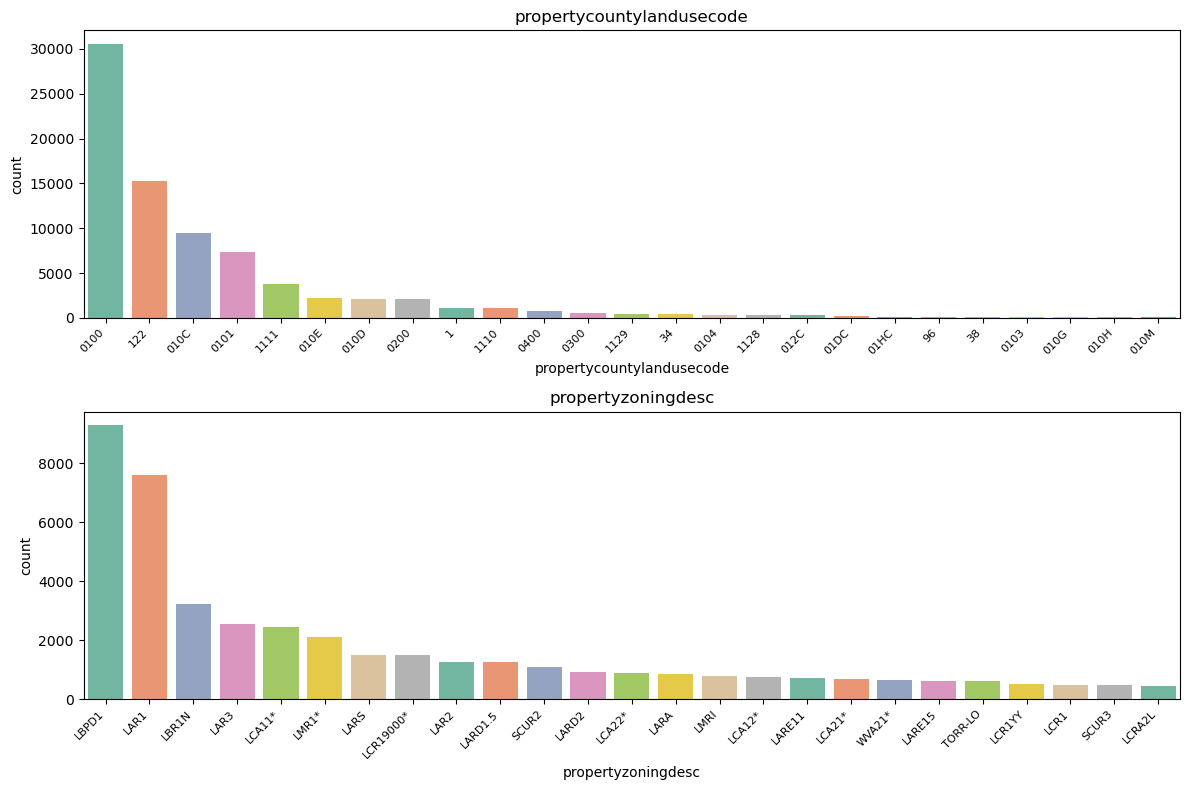

In [67]:
# Showing only the top 25 for each categorical feature
cat_features = df_cat.columns

cols = 1
rows = math.ceil(len(cat_features) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4), squeeze=False)

for ax, feature in zip(axes.flat, cat_features):
    top_25 = df_cat[feature].value_counts().nlargest(25).index
    filtered_data = df_cat[df_cat[feature].isin(top_25)]
    
    sns.countplot(ax=ax, data=filtered_data, x=feature, order=top_25, palette='Set2')
    
    if ax.legend_:
        ax.legend_.remove()
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, rotation=45, ha="right")
    ax.set_title(feature)

for ax in axes.flat[len(cat_features):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

----------**Conclusiones**----------

Gráfico 1: `propertycountylandusecode`

**Observaciones**:

1. Distribución altamente desbalanceada:

    - El código "0100" domina con mucha diferencia, representando más de 30,000 propiedades.

    - Otros códigos relevantes con alta frecuencia incluyen "122", "010C", y "0101".

    - La mayoría de los demás códigos tienen frecuencias muy bajas, con un descenso abrupto después de los principales.

2. Conclusión:

    - El código "0100" probablemente representa un tipo de propiedad común, como viviendas residenciales estándar.

    - Este desequilibrio puede ser relevante.

---

Gráfico 2: `propertyzoningdesc`

**Observaciones**:

1. También muestra un desbalance significativo:

    - La descripción "LBPD1" tiene la mayor cantidad de propiedades, con más de 8,000 registros.

    - Las siguientes descripciones más comunes son "LAR1", "LBR1N", y "LAR3", con frecuencias en el rango de miles.

    - Más allá de las primeras, las frecuencias disminuyen gradualmente y se distribuyen entre muchas descripciones menos comunes.

2. Conclusión:

    - Similar al primer gráfico, parece haber una concentración en unos pocos códigos de zonificación.

---

### 4. Multivariate Analysis <a class="anchor" id="c4"></a>
#### 4.1 Encoding Categorical Values and Saving JSON files <a id="s41"></a>

In [70]:
df_enc = df_merged.copy()
df_enc = df_enc.drop(columns='parcelid')
df_enc = df_enc[df_enc['calculatedfinishedsquarefeet'] != 0]

# Creating encoders for categorical features and saving them as JSON files. All files prefixed with 'enc'
# contain the encoding dictionaries for each categorical feature.
for column in df_cat.columns:
    unique_values = list(df_cat[column].unique())
    globals()[f"{column}_enc"] = dict(zip(unique_values, range(len(unique_values))))

    json.dump(globals()[f"{column}_enc"], open(f'../data/interim/enc_{column}.json', 'w'))

# Replacing the values in our categorical features to our encoded values (numerical)
for column in df_cat.columns:
    df_enc[column] = df_enc[column].map(json.load(open(f'../data/interim/enc_{column}.json')))

---

#### 4.2 Numerical-Categorical Analysis (Correlation Analysis) <a id="s42"></a>

In [71]:
# Since these 3 features only have one value, we will drop them. 
print(df_enc.transaction_year.unique(),df_enc.assessmentyear.unique(), df_enc.pooltypeid10.unique())

feat_oneval = ['transaction_year', 'assessmentyear', 'pooltypeid10']
df_enc = df_enc.drop(columns=feat_oneval)
df_enc.head(3)

[2016] [2015.] [0.]


logerror  transaction_day  transaction_month  transaction_dayofweek  \
0     0.028                1                  1                      4   
1    -0.168                1                  1                      4   
2    -0.004                1                  1                      4   

   airconditioningtypeid  basementsqft  bathroomcnt  bedroomcnt  \
0                  1.000         0.000        2.000       3.000   
1                  0.000         0.000        3.500       4.000   
2                  1.000         0.000        3.000       2.000   

   buildingqualitytypeid  calculatedbathnbr  decktypeid  \
0                  4.000              2.000       0.000   
1                  4.000              3.500       0.000   
2                  4.000              3.000       0.000   

   finishedfloor1squarefeet  calculatedfinishedsquarefeet  \
0                     0.000                      1684.000   
1                     0.000                      2263.000   
2                     0.000                      2217.000   

   finishedsquarefeet12  finishedsquarefeet13  finishedsquarefeet15  \
0              1684.000                 0.000                 0.000   
1              2263.000                 0.000                 0.000   
2              2217.000                 0.000                 0.000   

   finishedsquarefeet50  finishedsquarefeet6     fips  fireplacecnt  \
0                 0.000                0.000 6037.000         0.000   
1                 0.000                0.000 6059.000         0.000   
2                 0.000                0.000 6037.000         0.000   

   fullbathcnt  garagecarcnt  garagetotalsqft  hashottuborspa  \
0        2.000         0.000            0.000               0   
1        3.000         2.000          468.000               0   
2        3.000         0.000            0.000               0   

   heatingorsystemtypeid  latitude  longitude  lotsizesquarefeet  poolcnt  \
0                  2.000    34.281   -118.489           7528.000    0.000   
1                  0.000    33.668   -117.678           3643.000    0.000   
2                  2.000    34.136   -118.175          11423.000    0.000   

   poolsizesum  pooltypeid2  pooltypeid7  propertycountylandusecode  \
0        0.000        0.000        0.000                          0   
1        0.000        0.000        0.000                          1   
2        0.000        0.000        0.000                          0   

   propertylandusetypeid  propertyzoningdesc  rawcensustractandblock  \
0                261.000                   0            60371066.461   
1                261.000                   1            60590524.222   
2                261.000                   2            60374638.003   

   regionidcity  regionidcounty  regionidneighborhood  regionidzip  roomcnt  \
0     12447.000        3101.000             31817.000    96370.000    0.000   
1     32380.000        1286.000            403197.000    96962.000    0.000   
2     47019.000        3101.000            275411.000    96293.000    0.000   

   threequarterbathnbr  unitcnt  yardbuildingsqft17  yardbuildingsqft26  \
0                0.000    1.000               0.000               0.000   
1                1.000    0.000               0.000               0.000   
2                0.000    1.000               0.000               0.000   

   yearbuilt  numberofstories  fireplaceflag  structuretaxvaluedollarcnt  \
0   1959.000            0.000              0                  122754.000   
1   2014.000            0.000              0                  346458.000   
2   1940.000            0.000              0                   61994.000   

   taxvaluedollarcnt  landtaxvaluedollarcnt  taxamount  taxdelinquencyflag  \
0         360170.000             237416.000   6735.880                   0   
1         585529.000             239071.000  10153.020                   0   
2         119906.000              57912.000  11484.480                   0   

   ta

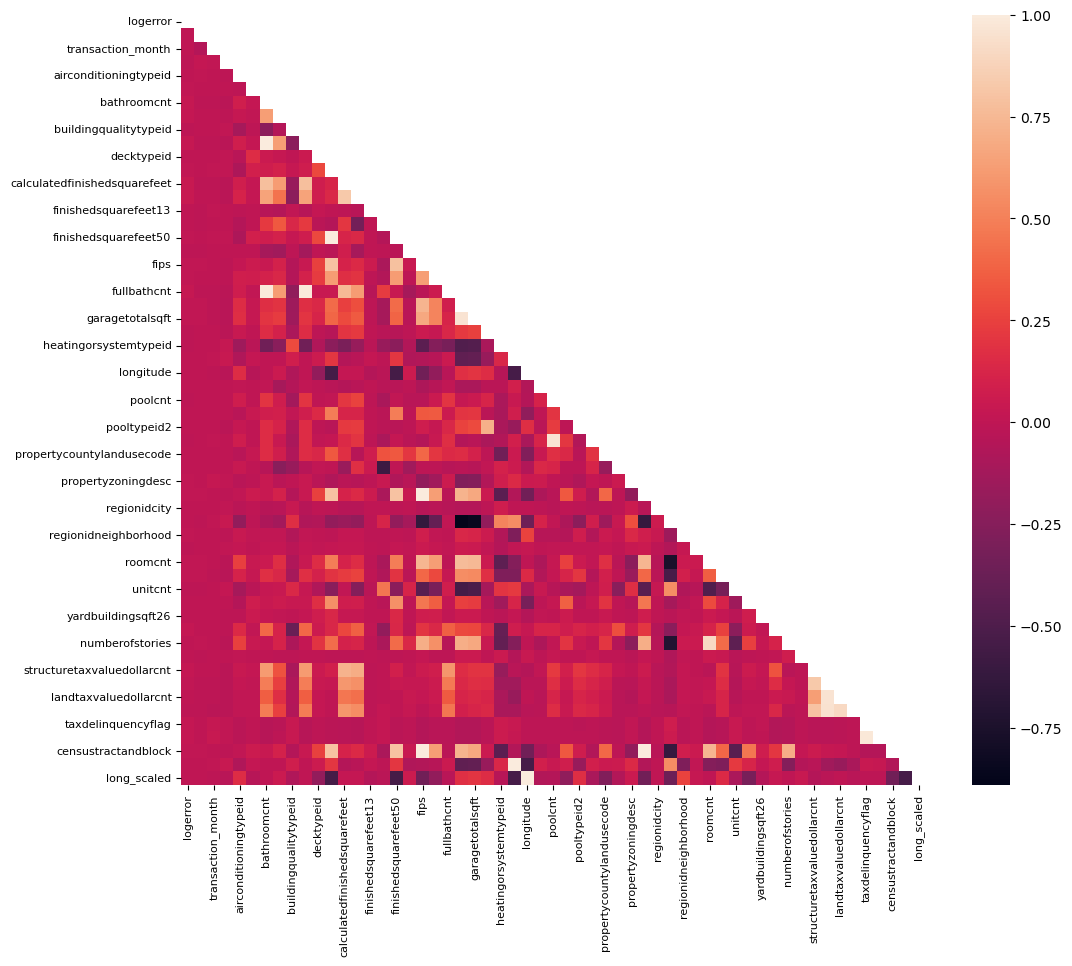

In [74]:
plt.figure(figsize=(12,10))
sns.heatmap(df_enc.corr().round(2), mask=np.triu(df_enc.corr()))
plt.yticks(fontsize=8, fontweight='light')
plt.xticks(fontsize=8, fontweight='light')
plt.show()

----------**Observaciones Generales**----------


1. Variables con alta correlación positiva (valores cercanos a 1, blanco):

    - Variables relacionadas con tamaños y áreas parecen tener una correlación positiva fuerte. Por ejemplo:

        - `calculatedfinishedsquarefeet` con `finishedsquarefeet13`.

        - `structuretaxvaluedollarcnt` con `landtaxvaluedollarcnt`.

Esto es lógico, ya que áreas construidas más grandes tienden a tener valores de estructura más altos.

2. Variables con correlación negativa (valores cercanos a -1, oscuro):

    - Hay menos relaciones claramente negativas, pero podría haber algunas con valores moderados. Estas serían interesantes para estudiar si afectan negativamente el objetivo del modelo (por ejemplo, logerror).

3. Variables con baja correlación (valores cercanos a 0):

    - La mayoría de las combinaciones muestran colores rojizos, lo que indica que no tienen una relación lineal fuerte.

    - Esto puede sugerir que algunas variables no son útiles para predecir el objetivo.

---

### 5. Feature Engineering <a class="anchor" id="c5"></a>
#### 5.1 New feature Inference <a id="s51"></a>

In [79]:
# Relationship between no. of bathrooms vs no. of bedrooms
df_enc['bath_bed_ratio'] = np.where(df_enc['bedroomcnt']==0, 0, df_enc['bathroomcnt'] / df_enc['bedroomcnt'])

# Total area being sold 
df_enc['total_area'] = df_enc['calculatedfinishedsquarefeet'] + df_enc['lotsizesquarefeet']

# Unused area being sold 
df_enc['unused_lot_space'] = df_enc['lotsizesquarefeet'] - df_enc['calculatedfinishedsquarefeet']

# Property age
df_enc['property_age'] = 2017 - df_enc['yearbuilt']

# Distance to LA city center
def distance_to_la(lat, lon):
    la_lat, la_lon = 34.0500, -118.2500

    lat_dist = abs(lat - la_lat)
    lon_dist = abs(lon - la_lon)

    dist = round(lat_dist + lon_dist,5)
    return dist 

df_enc['distantce_to_la'] = df_enc.apply(lambda row: distance_to_la(row['latitude'], row['longitude']), axis=1)

# Price per square feet
df_enc['price_per_sqft'] = df_enc['taxvaluedollarcnt'] / df_enc['calculatedfinishedsquarefeet']

# Lot size ratio
df_enc['lot_sqft_ratio'] = df_enc['lotsizesquarefeet'] / df_enc['calculatedfinishedsquarefeet']

---

#### 5.2 Outlier Analysis <a id="s52"></a>

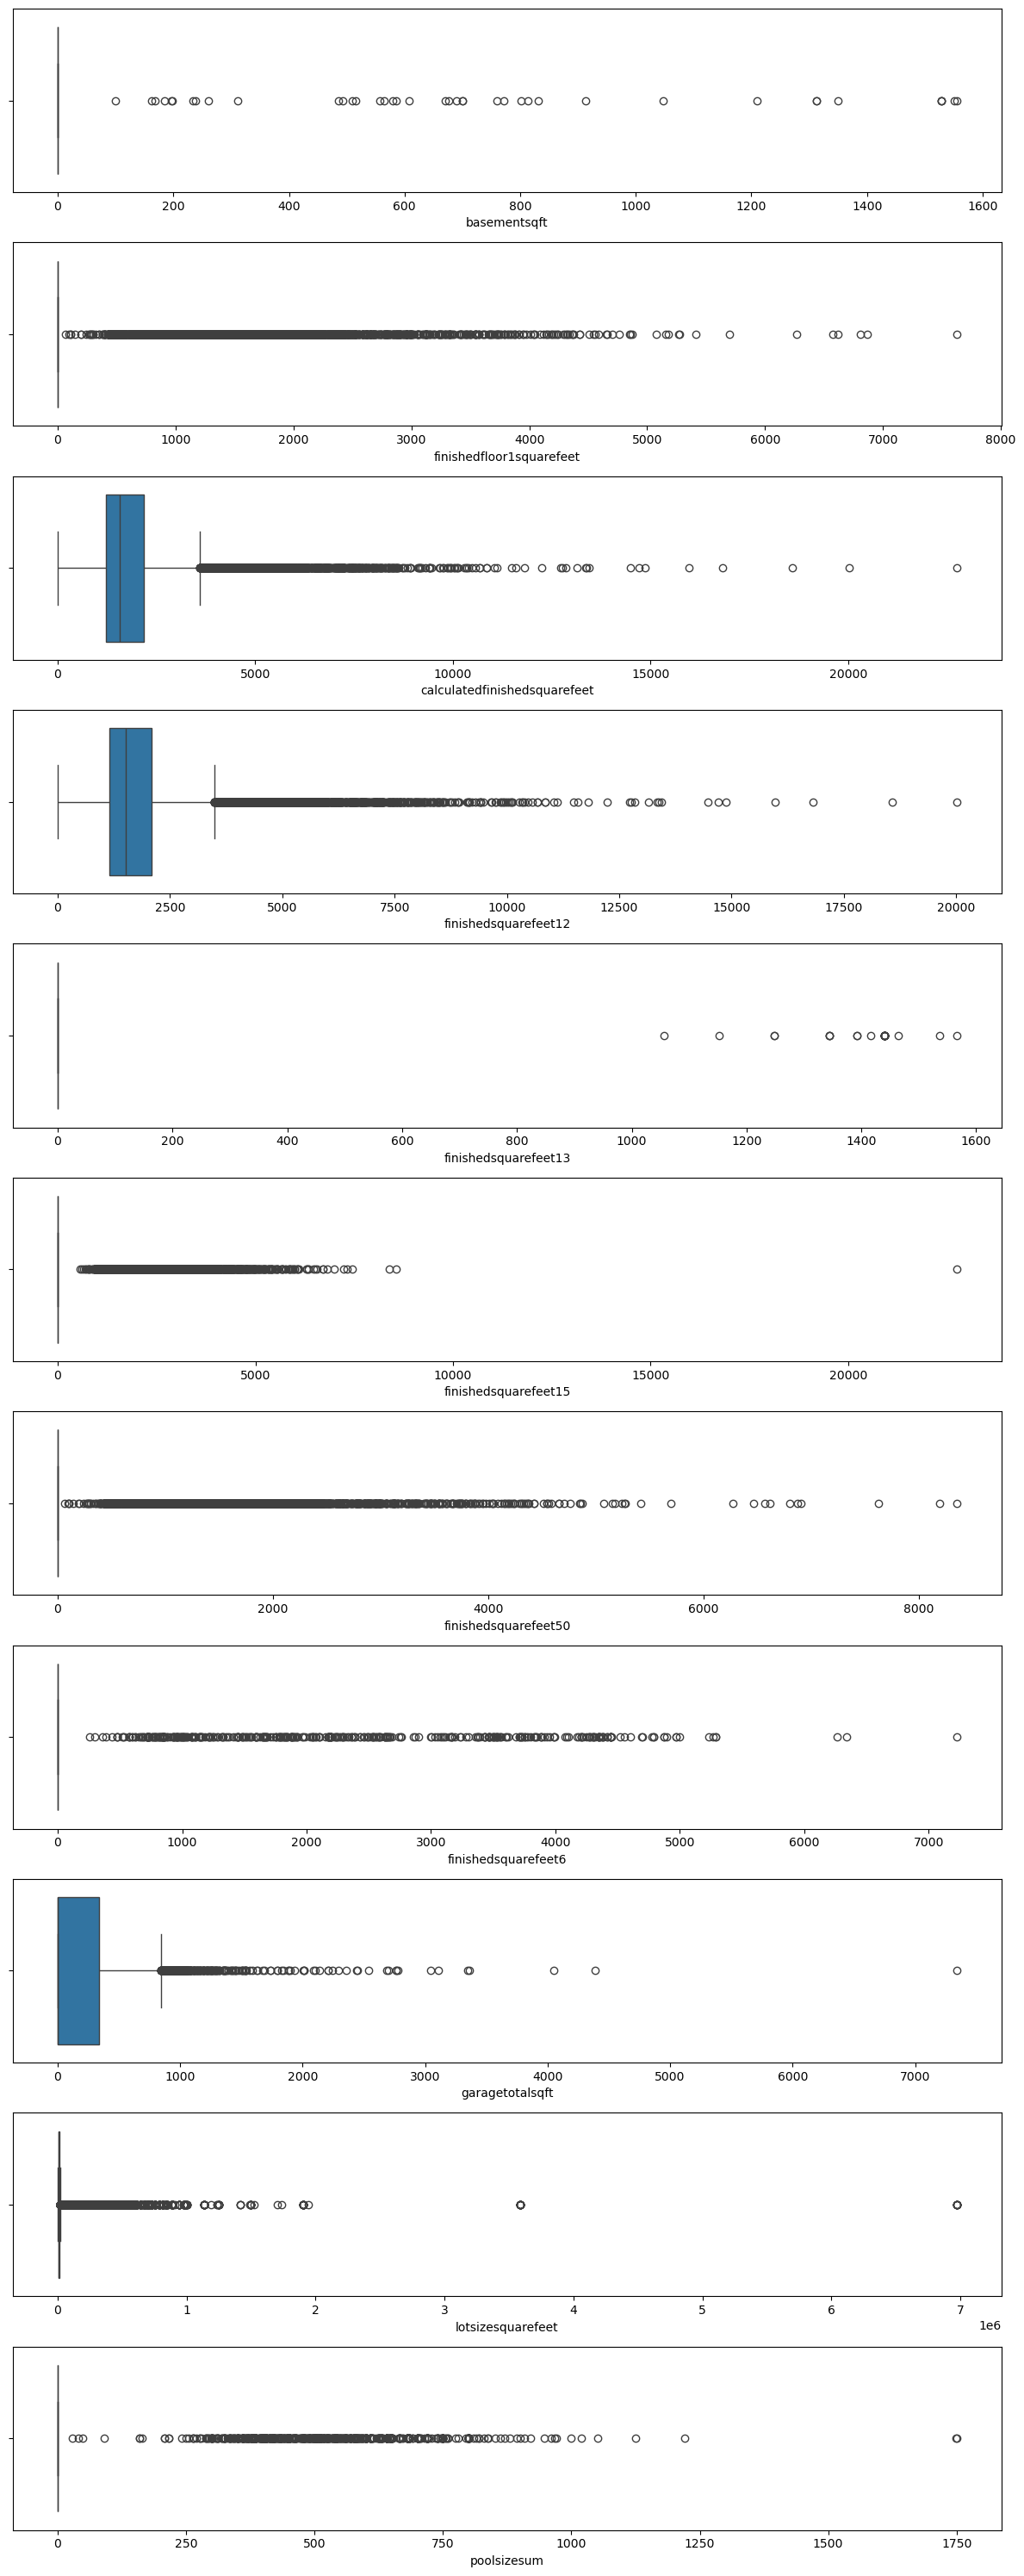

In [ ]:
continuos_f = ['basementsqft', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
                'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
                  'finishedsquarefeet50', 'finishedsquarefeet6', 'garagetotalsqft',
                    'lotsizesquarefeet', 'poolsizesum']

fig, ax = plt.subplots(11, figsize=(12, 30))

row=0
for each in continuos_f:
    sns.boxplot(ax = ax[row], data = df_enc, x=each)
    row += 1
    
plt.tight_layout()
plt.show()

----------**Observaciones Generales**----------
1. Boxplots por variable:

    - Cada gráfico representa una variable diferente, como basementsqft, calculatedfinishedsquarefeet, garagetotalsqft, entre otras.

    - Algunos tienen una gran concentración de datos cerca de la parte inferior del rango, mientras que otros muestran valores extremos (outliers) muy alejados de la mayoría.

2. Valores atípicos:

    - Muchas de las variables parecen tener un rango de valores estándar relativamente pequeño, pero también contienen varios valores atípicos que se alejan considerablemente.

3. Variables con alta dispersión:

    - Por ejemplo, en variables como lotizesquarefeet y finishedsquarefeet50, hay valores extremadamente altos que podrían influir negativamente en los modelos predictivos si no se manejan adecuadamente.

---

In [81]:
# # Creating a copy of our df to remove outliers 
df_enc_no = df_enc.copy()

# # This function returns our new df without outliers and the features' limits.  
def remove_outliers(x, feature_name, allow_neg=True):
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_lim = q3 + (iqr*1.5)
    lower_lim = q1 - (iqr*1.5) if allow_neg else max(0, q1 - (iqr * 1.5))

    x = x.apply(lambda x: upper_lim if (x > upper_lim) else (lower_lim if (x < lower_lim) else x))

    filename = f'../data/interim/outliers_lims_{feature_name}.json'
    json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, open(filename, 'w'))

    return x

In [82]:
f_outliers_with_neg = []
f_outliers_no_neg = []

for each in continuos_f:
    if df_enc[each].min() < 0:
        f_outliers_with_neg.append(each)
    f_outliers_no_neg.append(each)

for feature in f_outliers_with_neg:
    df_enc_no[feature] = remove_outliers(df_enc_no[feature], feature)

for feature in f_outliers_no_neg:
    df_enc_no[feature] = remove_outliers(df_enc_no[feature], feature, allow_neg=False)

In [83]:
df_enc.head(3)

logerror  transaction_day  transaction_month  transaction_dayofweek  \
0     0.028                1                  1                      4   
1    -0.168                1                  1                      4   
2    -0.004                1                  1                      4   

   airconditioningtypeid  basementsqft  bathroomcnt  bedroomcnt  \
0                  1.000         0.000        2.000       3.000   
1                  0.000         0.000        3.500       4.000   
2                  1.000         0.000        3.000       2.000   

   buildingqualitytypeid  calculatedbathnbr  decktypeid  \
0                  4.000              2.000       0.000   
1                  4.000              3.500       0.000   
2                  4.000              3.000       0.000   

   finishedfloor1squarefeet  calculatedfinishedsquarefeet  \
0                     0.000                      1684.000   
1                     0.000                      2263.000   
2                     0.000                      2217.000   

   finishedsquarefeet12  finishedsquarefeet13  finishedsquarefeet15  \
0              1684.000                 0.000                 0.000   
1              2263.000                 0.000                 0.000   
2              2217.000                 0.000                 0.000   

   finishedsquarefeet50  finishedsquarefeet6     fips  fireplacecnt  \
0                 0.000                0.000 6037.000         0.000   
1                 0.000                0.000 6059.000         0.000   
2                 0.000                0.000 6037.000         0.000   

   fullbathcnt  garagecarcnt  garagetotalsqft  hashottuborspa  \
0        2.000         0.000            0.000               0   
1        3.000         2.000          468.000               0   
2        3.000         0.000            0.000               0   

   heatingorsystemtypeid  latitude  longitude  lotsizesquarefeet  poolcnt  \
0                  2.000    34.281   -118.489           7528.000    0.000   
1                  0.000    33.668   -117.678           3643.000    0.000   
2                  2.000    34.136   -118.175          11423.000    0.000   

   poolsizesum  pooltypeid2  pooltypeid7  propertycountylandusecode  \
0        0.000        0.000        0.000                          0   
1        0.000        0.000        0.000                          1   
2        0.000        0.000        0.000                          0   

   propertylandusetypeid  propertyzoningdesc  rawcensustractandblock  \
0                261.000                   0            60371066.461   
1                261.000                   1            60590524.222   
2                261.000                   2            60374638.003   

   regionidcity  regionidcounty  regionidneighborhood  regionidzip  roomcnt  \
0     12447.000        3101.000             31817.000    96370.000    0.000   
1     32380.000        1286.000            403197.000    96962.000    0.000   
2     47019.000        3101.000            275411.000    96293.000    0.000   

   threequarterbathnbr  unitcnt  yardbuildingsqft17  yardbuildingsqft26  \
0                0.000    1.000               0.000               0.000   
1                1.000    0.000               0.000               0.000   
2                0.000    1.000               0.000               0.000   

   yearbuilt  numberofstories  fireplaceflag  structuretaxvaluedollarcnt  \
0   1959.000            0.000              0                  122754.000   
1   2014.000            0.000              0                  346458.000   
2   1940.000            0.000              0                   61994.000   

   taxvaluedollarcnt  landtaxvaluedollarcnt  taxamount  taxdelinquencyflag  \
0         360170.000             237416.000   6735.880                   0   
1         585529.000             239071.000  10153.020                   0   
2         119906.000              57912.000  11484.480                   0   

   ta

---

### 6. Data Processing <a class="anchor" id="c6"></a>
#### 6.1 Feature Selection based on Importance <a id="s61"></a>

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7655
[LightGBM] [Info] Number of data points in the train set: 63697, number of used features: 63
[LightGBM] [Info] Start training from score 0.012587


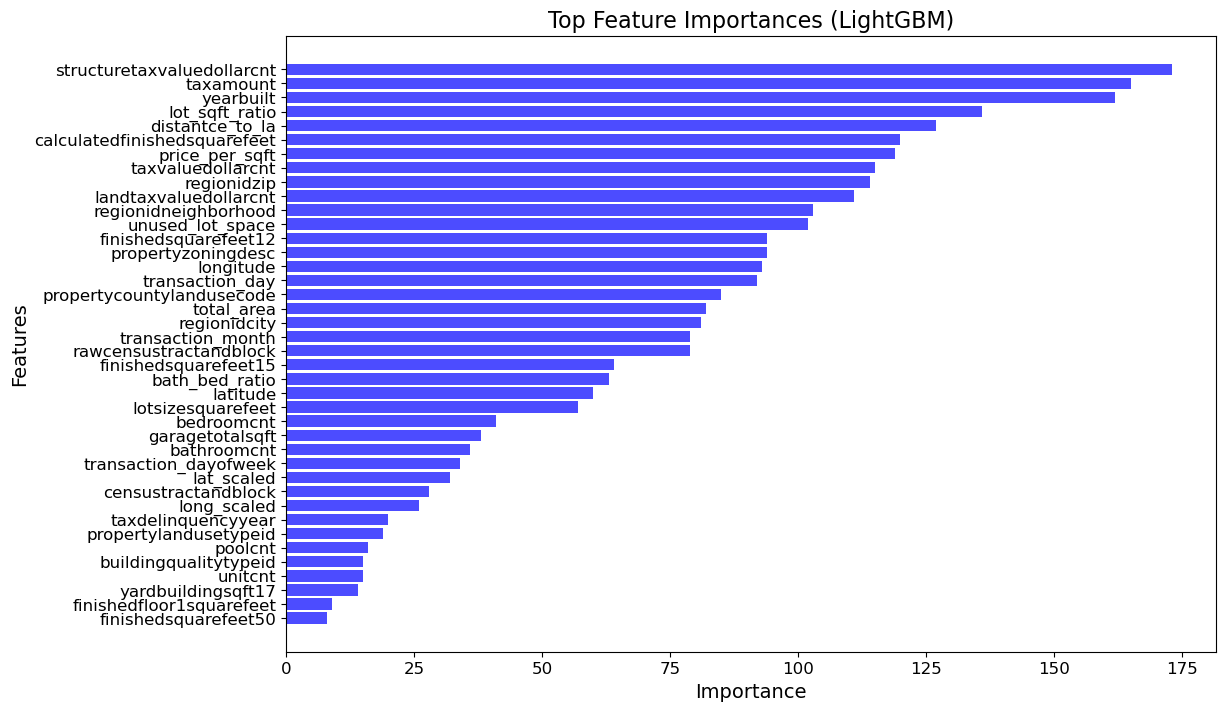

In [87]:
df_test = df_enc.copy()

X = df_test.drop(columns=['logerror'])  # Reemplaza 'logerror' con el nombre de tu columna target
y = df_test['logerror']

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Using LightGBM model to obtain feature importance
model = lgb.LGBMRegressor(random_state=123)
model.fit(X_train, y_train)

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Selecting the top most important features
top_n = 40
top_features = feature_importances.head(top_n)

# Plot the top N features
plt.figure(figsize=(12, 8))  # Increase the figure size
plt.barh(top_features['Feature'], top_features['Importance'], color='blue', alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.title('Top Feature Importances (LightGBM)', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

---------------**Desglose**---------------

1. Características más importantes:

    - `structuretaxvaluedollarcnt`: Esta característica tiene la mayor importancia, sugiriendo que el valor de la estructura (posiblemente relacionado con el impuesto) es crucial para las predicciones.

    - `taxamount`: El monto del impuesto también es altamente relevante.

    - `yearbuilt`: El año de construcción de la propiedad juega un papel importante en las estimaciones.

    - `lot_sqft_ratio` y `distance_to_la`: Factores espaciales y proporcionales del terreno tienen un impacto significativo.

    - `calculatedfinishedsquarefeet`: El área terminada de la propiedad es clave.

2. Características moderadamente importantes:

    - `price_per_sqft` y `taxvaluedollarcnt`: Indicadores directos del valor de la propiedad.

    - Variables geográficas como `regionidzip` y `regionidneighborhood`.

    - Dimensiones específicas de la vivienda (`finishedsquarefeet12`, `finishedsquarefeet15`).

3. Características menos importantes:

    - `yardbuildingsqft17`, `poolcnt`, y `finishedfloor1squarefeet50` tienen menor influencia en las predicciones.

    
---------------**Conclusiones**---------------

- Factores fiscales (`structuretaxvaluedollarcnt`, `taxamount`) dominan la importancia, reflejando cómo los impuestos y evaluaciones fiscales están estrechamente relacionados con los valores reales de las propiedades.

- Factores espaciales y físicos como la superficie (`calculatedfinishedsquarefeet`) y la ubicación (`regionidzip`, `longitude`, `latitude`) tienen un peso considerable.

- Las características relacionadas con el diseño específico (p. ej., `bath_bed_ratio`, `garage`) contribuyen de manera menor pero no despreciable.

In [88]:
# Define the threshold and dropping the rest 
importance_threshold = 50  # Example threshold
low_importance_features = feature_importances[feature_importances['Importance'] < importance_threshold]['Feature']

# Drop low-importance features
df_test = df_test.drop(columns=low_importance_features)
len(df_test.columns)

26

In [89]:
# Calculate the correlation matrix
correlation_matrix = df_test.corr()

# Find pairs of features with high correlation
threshold = 0.85
high_correlation_pairs = [(col1, col2) for col1 in correlation_matrix.columns for col2 in correlation_matrix.columns
                          if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > threshold]

print(f"Highly correlated feature pairs: {high_correlation_pairs}")

Highly correlated feature pairs: [('lotsizesquarefeet', 'total_area'), ('lotsizesquarefeet', 'unused_lot_space'), ('lotsizesquarefeet', 'lot_sqft_ratio'), ('taxvaluedollarcnt', 'landtaxvaluedollarcnt'), ('taxvaluedollarcnt', 'taxamount'), ('landtaxvaluedollarcnt', 'taxvaluedollarcnt'), ('landtaxvaluedollarcnt', 'taxamount'), ('taxamount', 'taxvaluedollarcnt'), ('taxamount', 'landtaxvaluedollarcnt'), ('total_area', 'lotsizesquarefeet'), ('total_area', 'unused_lot_space'), ('total_area', 'lot_sqft_ratio'), ('unused_lot_space', 'lotsizesquarefeet'), ('unused_lot_space', 'total_area'), ('unused_lot_space', 'lot_sqft_ratio'), ('lot_sqft_ratio', 'lotsizesquarefeet'), ('lot_sqft_ratio', 'total_area'), ('lot_sqft_ratio', 'unused_lot_space')]


In [90]:
# Drop the less important feature in each pair -> highly correlated features pairs are being dropped, to keep only one. 
features_to_drop = []
for col1, col2 in high_correlation_pairs:
    if col1 not in features_to_drop and col2 not in features_to_drop:
        # Drop the less important feature
        if feature_importances[feature_importances['Feature'] == col1]['Importance'].values[0] < feature_importances[feature_importances['Feature'] == col2]['Importance'].values[0]:
            features_to_drop.append(col1)
        else:
            features_to_drop.append(col2)

# Drop the correlated features
df_test = df_test.drop(columns=features_to_drop)
print(f"Dropped a total of {len(features_to_drop)} highly correlated features.")

Dropped a total of 5 highly correlated features.


In [91]:
df_test.to_csv('../data/processed/fulleda_final.csv', index=False)

In [92]:
df_test = pd.read_csv('../data/processed/fulleda_final.csv')

---

#### 6.2 Split train/test <a id="s62"></a>

In [93]:
# Split the processed data 
X = df_test.drop(columns=['logerror'])
y = df_test['logerror']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

---

### Machine Learning
#### 7.1 Decision Making: Which is the best model? <a id="s71"></a>

In [94]:
# Evaluating individual models and selecting the best 3 for ensembling
lgb_model = LGBMRegressor(random_state=123)
xgb_model = XGBRegressor(random_state=123)
cat_model = CatBoostRegressor(verbose=0, random_state=123)
rfr_model = RandomForestRegressor(random_state=123)

for name, model in [('LightGBM', lgb_model), ('XGBoost', xgb_model), ('CatBoost', cat_model), ('RandomForest', rfr_model)]:
    model.fit(X_train, y_train)
    y_pred_individual = model.predict(X_test)
    mae_individual = mean_absolute_error(y_test, y_pred_individual)
    print(f"MAE of {name}: {mae_individual:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4008
[LightGBM] [Info] Number of data points in the train set: 63697, number of used features: 20
[LightGBM] [Info] Start training from score 0.012587
MAE of LightGBM: 0.0710
MAE of XGBoost: 0.0752
MAE of CatBoost: 0.0720
MAE of RandomForest: 0.0754


In [95]:
# Ensemble model (default) -> best individual models where LightGBM, XGBoost & CatBoost 
ensemble_model = VotingRegressor(estimators=[('lgb', lgb_model), ('xgb', xgb_model), ('cat', cat_model)])
ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE of the ensemble model: {mae:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4008
[LightGBM] [Info] Number of data points in the train set: 63697, number of used features: 20
[LightGBM] [Info] Start training from score 0.012587
MAE of the ensemble model: 0.0717


---

#### 7.2 Model Optimization <a id="s72"></a> 
We will try with both LightGBM and Ensemble model, to see which was has the best MAE. 
##### 7.2.1 LightGBM Opmitization <a id="s721"></a>

In [97]:
lgb_param_grid = {
    'num_leaves': [30, 50, 70, 100],         
    'learning_rate': [0.01, 0.05, 0.1], 
    'max_depth': [-1, 10, 20],          
    'min_child_samples': [10, 20, 30],  
    'subsample': [0.6, 0.8, 1.0],       
    'colsample_bytree': [0.6, 0.8, 1.0]
}

lgb_model = lgb.LGBMRegressor(random_state=123)

grid_lgb = GridSearchCV(
    estimator=lgb_model,
    param_grid=lgb_param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid_lgb.fit(X_train, y_train)
print(f"Best parameters for LightGBM: {grid_lgb.best_params_}")

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4004
[LightGBM] [Info] Number of data points in the train set: 50957, number of used features: 20
[LightGBM] [Info] Start training from score 0.012454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 50957, number of used features: 20
[LightGBM] [Info] Start training from score 0.012730
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4002
[LightGBM] [Info] Number of data points in the train set

In [98]:
# Train LightGBM with best params
model = lgb.LGBMRegressor(random_state=123, colsample_bytree=0.6, learning_rate=0.01, max_depth=10,
                          min_child_samples=30, num_leaves=50)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {mae:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4008
[LightGBM] [Info] Number of data points in the train set: 63697, number of used features: 20
[LightGBM] [Info] Start training from score 0.012587
RMSE: 0.0697


---

##### 7.2.2 Ensemble Optimization <a id="s722"></a>

In [591]:
# XGBoost GridSearch
# =======================================================================================
xgb_param_grid = {
    'n_estimators': [100, 200, 300],        
    'learning_rate': [0.01, 0.05, 0.1],    
    'max_depth': [3, 5, 7],                
    'subsample': [0.6, 0.8, 1.0],          
    'colsample_bytree': [0.6, 0.8, 1.0],   
    'min_child_weight': [1, 5, 10],        
    'gamma': [0, 0.1, 0.2]                 
}

xgb_model = XGBRegressor(random_state=123, use_label_encoder=False, eval_metric='mae')

grid_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid_xgb.fit(X_train, y_train)
print(f"Best parameters for XGBoost: {grid_xgb.best_params_}")

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Best parameters for XGBoost: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.8}


In [80]:
# CatBoost GridSearch
# =======================================================================================
cat_param_grid = {
    'iterations': [500, 1000],             # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],   # Step size for updates
    'depth': [4, 6, 8],                   # Maximum tree depth
    'l2_leaf_reg': [1, 3, 5],             # Regularization term
    'bagging_temperature': [0.1, 1, 3],   # Subsample ratio for bagging
    'border_count': [32, 64, 128]         # Number of splits for numerical features
}

cat_model = CatBoostRegressor(verbose=0, random_state=123)

grid_cat = GridSearchCV(
    estimator=cat_model,
    param_grid=cat_param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1,
    # n_jobs=-1
)

grid_cat.fit(X_train, y_train)
print(f"Best parameters for CatBoost: {grid_cat.best_params_}")

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best parameters for CatBoost: {'bagging_temperature': 0.1, 'border_count': 32, 'depth': 8, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.01}


In [99]:
# Optimized models for the ensamble
# =======================================================================================
lgb_best = lgb.LGBMRegressor(colsample_bytree=0.6, learning_rate=0.01, max_depth=10, min_child_samples=30, num_leaves=70, 
                             subsample=0.6, random_state=123)

xgb_best = XGBRegressor(colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=10, n_estimators=100,
                        subsample=0.8, random_state=123)

cat_best = CatBoostRegressor(bagging_temperature=0.1, border_count=32, depth=8, iterations=500, l2_leaf_reg=5, learning_rate=0.01, 
                             verbose=0, random_state=123)

# Ensemble model
# =======================================================================================
ensemble_model = VotingRegressor(estimators=[
    ('lgb', lgb_best),
    ('xgb', xgb_best),
    ('cat', cat_best)
])

ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)

print(f"MAE of Ensemble Model: {mae_ensemble:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4008
[LightGBM] [Info] Number of data points in the train set: 63697, number of used features: 20
[LightGBM] [Info] Start training from score 0.012587
MAE of Ensemble Model: 0.0696


In [100]:
# Serializa `ensemble_model` en un formato binario para que pueda guardarse en un archivo

pickle.dump(ensemble_model, open('ensemble.sav', 'wb'))